# American Footbal Big Data Insights

In this notebook we explore the data pro
vided on the kaggle competition "[NFL Big Data Bowl](https://www.kaggle.com/c/nfl-big-data-bowl-2020/data)".
The data describes 512 American Football games and definetely contains a lot of insights!
So, to start let's understand how to play American Football!

## The Rules

To understand the rules we advise you to watch [this video](https://www.youtube.com/watch?v=Ddwp1HyEFRE)

Full games you can find on [this channel](https://www.youtube.com/channel/UCP4Wts8iiR9-Ddfq7FK0x3g/videos)

Now, we are ready to take a look on the data!

## First look on the data

In [76]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
!ls data

train.csv  train.csv.zip


In [7]:
raw_data = pd.read_csv('data/train.csv')
raw_data.head()

/home/femoiseev/miniconda3/envs/ada/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509762 entries, 0 to 509761
Data columns (total 49 columns):
GameId                    509762 non-null int64
PlayId                    509762 non-null int64
Team                      509762 non-null object
X                         509762 non-null float64
Y                         509762 non-null float64
S                         509762 non-null float64
A                         509762 non-null float64
Dis                       509762 non-null float64
Orientation               509744 non-null float64
Dir                       509748 non-null float64
NflId                     509762 non-null int64
DisplayName               509762 non-null object
JerseyNumber              509762 non-null int64
Season                    509762 non-null int64
YardLine                  509762 non-null int64
Quarter                   509762 non-null int64
GameClock                 509762 non-null object
PossessionTeam            509762 non-null object
Down   

In [9]:
data = raw_data.copy()

As we see some features may be null and have object type. Some of them like PlayerCollegeName or HomeTeamAbbr are just strings with the same format, but some need special processing:

## String columns cleaning

**GameClock** is represented as strig in format hh:mm:ss and **PlayerBirthDate** in string with format mm/dd/yyyy.
In order to operate with it we will transform to the pd.datetime

In [13]:
data['GameClock'] = pd.to_datetime(raw_data['GameClock'], format='%H:%M:%S')
data['PlayerBirthDate'] = pd.to_datetime(raw_data['PlayerBirthDate'], format='%m/%d/%Y')
data[['GameClock', 'PlayerBirthDate']].head()

,GameClock,PlayerBirthDate
0,1900-01-01 14:14:00,1988-12-29
1,1900-01-01 14:14:00,1989-03-25
2,1900-01-01 14:14:00,1989-01-21
3,1900-01-01 14:14:00,1982-11-22
4,1900-01-01 14:14:00,1987-08-17


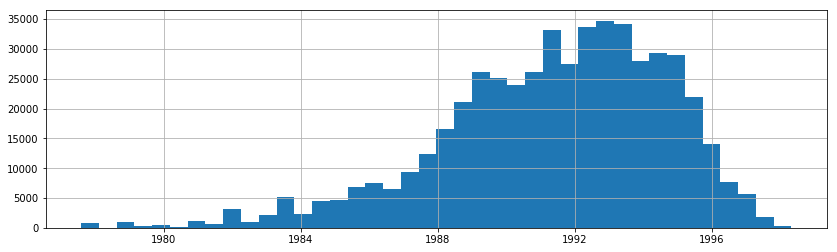

In [15]:
data['PlayerBirthDate'].hist(figsize=(14, 4), bins=40)
plt.show()

**PlayerHeight** is presented in one string with foots and inches in it. We will transform it to centimeters

In [16]:
raw_data[['PlayerHeight']].head()

,PlayerHeight
0,6-0
1,6-3
2,6-3
3,6-3
4,6-0


In [17]:
def ft_in_to_cm(string):
    foots, inches = string.split('-')
    foots, inches = int(foots), int(inches)
    return  30.48 * foots + 2.54 * inches

data['PlayerHeight'] = raw_data['PlayerHeight'].apply(ft_in_to_cm)
data[['PlayerHeight']].head()

,PlayerHeight
0,182.88
1,190.50
2,190.50
3,190.50
4,182.88


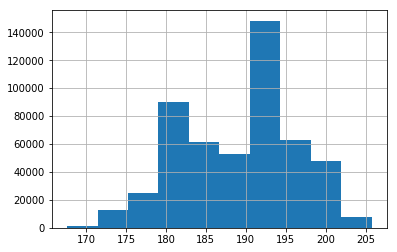

In [18]:
data['PlayerHeight'].hist()
plt.show()

**Stadium** is a string with name of stadium. As can we see from unique and sorted list of names there are some typos, which we will to correct 

In [19]:
stadiums = raw_data['Stadium'].unique()
stadiums.sort()
print(len(stadiums), stadiums)

55 ['AT&T Stadium' 'Arrowhead Stadium' 'Bank of America Stadium'
 'Broncos Stadium At Mile High' 'Broncos Stadium at Mile High'
 'CenturyField' 'CenturyLink' 'CenturyLink Field' 'Estadio Azteca'
 'EverBank Field' 'Everbank Field' 'FedExField' 'First Energy Stadium'
 'FirstEnergy' 'FirstEnergy Stadium' 'FirstEnergyStadium' 'Ford Field'
 'Gillette Stadium' 'Hard Rock Stadium' 'Heinz Field' 'Lambeau Field'
 'Lambeau field' 'Levis Stadium' 'Lincoln Financial Field'
 'Los Angeles Memorial Coliesum' 'Los Angeles Memorial Coliseum'
 'Lucas Oil Stadium' 'M & T Bank Stadium' 'M&T Bank Stadium' 'M&T Stadium'
 'Mercedes-Benz Dome' 'Mercedes-Benz Stadium' 'Mercedes-Benz Superdome'
 'MetLife' 'MetLife Stadium' 'Metlife Stadium' 'NRG' 'NRG Stadium'
 'New Era Field' 'Nissan Stadium' 'Oakland Alameda-County Coliseum'
 'Oakland-Alameda County Coliseum' 'Paul Brown Stadium'
 'Paul Brown Stdium' 'Raymond James Stadium' 'Soldier Field'
 'Sports Authority Field at Mile High' 'State Farm Stadium'
 'StubHub 

In [20]:
typos = {'Broncos Stadium At Mile High'   : 'Broncos Stadium at Mile High',
         'CenturyLink Field'              : 'CenturyLink',
         'Everbank Field'                 : 'EverBank Field',
         'FirstEnergyStadium'             : 'First Energy Stadium',
         'FirstEnergy'                    : 'First Energy Stadium',
         'FirstEnergy Stadium'            : 'First Energy Stadium',
         'Lambeau field'                  : 'Lambeau Field',
         'Los Angeles Memorial Coliesum'  : 'Los Angeles Memorial Coliseum',
         'M & T Bank Stadium'             : 'M&T Bank Stadium',
         'M&T Stadium'                    : 'M&T Bank Stadium',
         'MetLife'                        : 'MetLife Stadium',
         'Metlife Stadium'                : 'MetLife Stadium',
         'NRG'                            : 'NRG Stadium',
         'Oakland Alameda-County Coliseum': 'Oakland-Alameda County Coliseum',
         'Paul Brown Stdium'              : 'Paul Brown Stadium',
         'Twickenham'                     : 'Twickenham Stadium'
}

data['Stadium'] = raw_data['Stadium'].apply(lambda x: typos[x] if x in typos.keys() else x)
stadiums = data['Stadium'].unique()
stadiums.sort()
print(len(stadiums), stadiums)

39 ['AT&T Stadium' 'Arrowhead Stadium' 'Bank of America Stadium'
 'Broncos Stadium at Mile High' 'CenturyField' 'CenturyLink'
 'Estadio Azteca' 'EverBank Field' 'FedExField' 'First Energy Stadium'
 'Ford Field' 'Gillette Stadium' 'Hard Rock Stadium' 'Heinz Field'
 'Lambeau Field' 'Levis Stadium' 'Lincoln Financial Field'
 'Los Angeles Memorial Coliseum' 'Lucas Oil Stadium' 'M&T Bank Stadium'
 'Mercedes-Benz Dome' 'Mercedes-Benz Stadium' 'Mercedes-Benz Superdome'
 'MetLife Stadium' 'NRG Stadium' 'New Era Field' 'Nissan Stadium'
 'Oakland-Alameda County Coliseum' 'Paul Brown Stadium'
 'Raymond James Stadium' 'Soldier Field'
 'Sports Authority Field at Mile High' 'State Farm Stadium'
 'StubHub Center' 'TIAA Bank Field' 'Twickenham Stadium'
 'U.S. Bank Stadium' 'University of Phoenix Stadium' 'Wembley Stadium']


Google says that 'Mercedes-Benz Dome', 'Mercedes-Benz Stadium' and 'Mercedes-Benz Superdome' are 3 different stadiums.

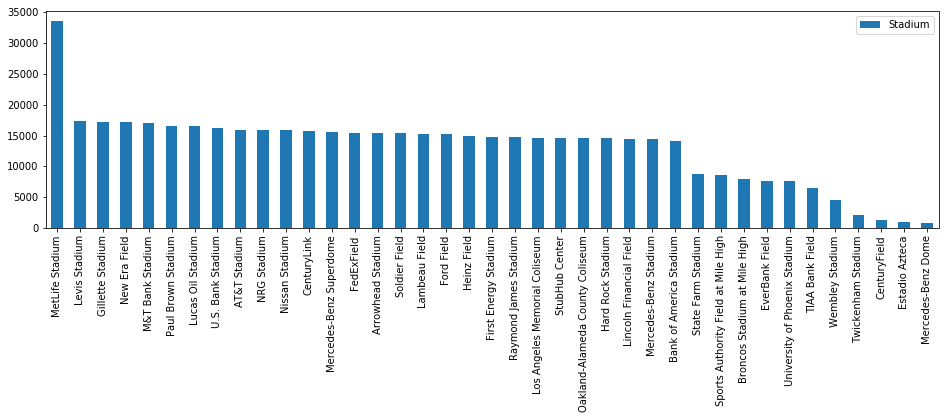

In [21]:
data[['Stadium']].apply(pd.value_counts).plot(kind='bar', figsize=(16, 4))
plt.show()

**StadiumType** – a string which again contains a lot of typos. 

'Heinz Field' and 'Cloudy' are not even a stadium type, so we will look for its value in other rows, as well as for nans

'Bowl' may be a type of stadion, but as we will see later it is seen only for one stadium together with other types, so we will also replace it with nan

In [22]:
stadium_type = data['StadiumType'].dropna().unique()
stadium_type.sort()
print(len(stadium_type), stadium_type)

29 ['Bowl' 'Closed Dome' 'Cloudy' 'Dome' 'Dome, closed' 'Domed' 'Domed, Open'
 'Domed, closed' 'Domed, open' 'Heinz Field' 'Indoor' 'Indoor, Open Roof'
 'Indoor, Roof Closed' 'Indoors' 'Open' 'Oudoor' 'Ourdoor' 'Outddors'
 'Outdoor' 'Outdoor Retr Roof-Open' 'Outdoors' 'Outdor' 'Outside'
 'Retr. Roof - Closed' 'Retr. Roof - Open' 'Retr. Roof Closed'
 'Retr. Roof-Closed' 'Retr. Roof-Open' 'Retractable Roof']


In [23]:
typos = {'Closed Dome'            : 'Dome-Closed',
         'Dome, closed'           : 'Dome-Closed',
         'Domed'                  : 'Dome',
         'Domed, closed'          : 'Dome-Closed',
         'Domed, open'            : 'Dome-Open',
         'Domed, Open'            : 'Dome-Open',
         'Indoors'                : 'Indoor',
         'Oudoor'                 : 'Outdoor',
         'Ourdoor'                : 'Outdoor',
         'Outddors'               : 'Outdoor',
         'Outdoors'               : 'Outdoor',
         'Outdor'                 : 'Outdoor',
         'Outside'                : 'Outdoor',
         'Retr. Roof Closed'      : 'Closed',
         'Retr. Roof-Closed'      : 'Closed',
         'Retr. Roof - Closed'    : 'Closed',
         'Retr. Roof - Open'      : 'Open',
         'Retr. Roof-Open'        : 'Open',
         'Outdoor Retr Roof-Open' : 'Open',
         'Indoor, Roof Closed'    : 'Indoor-Closed',
         'Indoor, Open Roof'      : 'Indoor-Open',
         'Heinz Field'            : np.nan,
         'Cloudy'                 : np.nan,
         'Bowl'                   : np.nan
}

data['StadiumType'] = raw_data['StadiumType'].apply(lambda x: typos[x] if x in typos.keys() else x)
stadium_type = data['StadiumType'].dropna().unique()
stadium_type.sort()
print(len(stadium_type), stadium_type)

10 ['Closed' 'Dome' 'Dome-Closed' 'Dome-Open' 'Indoor' 'Indoor-Closed'
 'Indoor-Open' 'Open' 'Outdoor' 'Retractable Roof']


In [24]:
data.groupby(by=['Stadium'])['StadiumType'].unique()

Stadium
AT&T Stadium                                                 [Indoor, Outdoor]
Arrowhead Stadium                                                    [Outdoor]
Bank of America Stadium                                              [Outdoor]
Broncos Stadium at Mile High                                         [Outdoor]
CenturyField                                                         [Outdoor]
CenturyLink                                                          [Outdoor]
Estadio Azteca                                                       [Outdoor]
EverBank Field                                                          [Open]
FedExField                                                           [Outdoor]
First Energy Stadium                                                 [Outdoor]
Ford Field                                                            [Indoor]
Gillette Stadium                                                     [Outdoor]
Hard Rock Stadium                           

Google says that StubHub Center is outdoor stadium, AT&T Stadium is indoor, for others we just substitude nans

In [25]:
data.loc[data['Stadium'] == 'StubHub Center', 'StadiumType'] = 'Outdoor'
data.loc[data['Stadium'] == 'AT&T Stadium', 'StadiumType'] = 'Indoor'
data.loc[data['Stadium'] == 'Heinz Field', 'StadiumType'] = 'Outdoor'
data.loc[data['Stadium'] == 'MetLife Stadium', 'StadiumType'] = 'Outdoor'
data.loc[data['Stadium'] == 'TIAA Bank Field', 'StadiumType'] = 'Outdoor' # TODO there is a second value

In [26]:
data.groupby(by=['Stadium'])['StadiumType'].unique()

Stadium
AT&T Stadium                                                          [Indoor]
Arrowhead Stadium                                                    [Outdoor]
Bank of America Stadium                                              [Outdoor]
Broncos Stadium at Mile High                                         [Outdoor]
CenturyField                                                         [Outdoor]
CenturyLink                                                          [Outdoor]
Estadio Azteca                                                       [Outdoor]
EverBank Field                                                          [Open]
FedExField                                                           [Outdoor]
First Energy Stadium                                                 [Outdoor]
Ford Field                                                            [Indoor]
Gillette Stadium                                                     [Outdoor]
Hard Rock Stadium                           

That is much better!

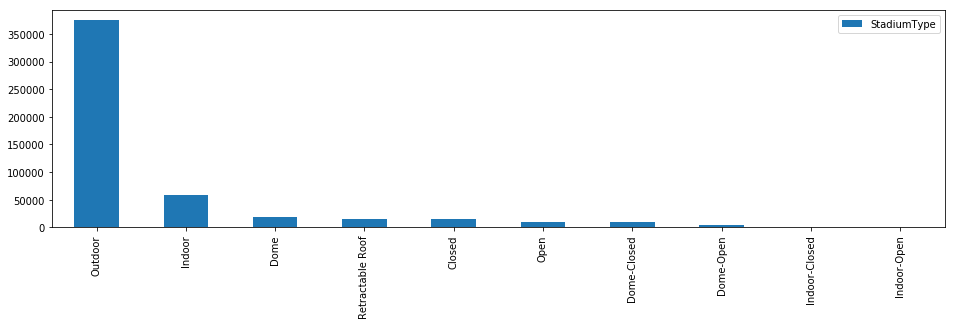

In [27]:
data[['StadiumType']].apply(pd.value_counts).plot(kind='bar', figsize=(16, 4))
plt.show()

TODO: Separate on several variables - indoor/outdoor/dome + open/closed, Where is retractable?

TODO: Is it any differenve between Dome and outdoor? 

**Turf** - again typos

In [28]:
turf = data['Turf'].dropna().unique()
turf.sort()
print(len(turf), turf)

20 ['A-Turf Titan' 'Artifical' 'Artificial' 'DD GrassMaster' 'Field Turf'
 'Field turf' 'FieldTurf' 'FieldTurf 360' 'FieldTurf360' 'Grass' 'Natural'
 'Natural Grass' 'Natural grass' 'Naturall Grass' 'SISGrass'
 'Twenty-Four/Seven Turf' 'UBU Speed Series-S5-M' 'UBU Sports Speed S5-M'
 'grass' 'natural grass']


In [29]:
typos = {'Natural grass'         : 'Natural Grass',
         'Naturall Grass'        : 'Natural Grass',
         'natural grass'         : 'Natural Grass',
         'Artifical'             : 'Artificial',
         'grass'                 : 'Grass',
         'Natural'               : 'Natural Grass',
         'FieldTurf360'          : 'FieldTurf 360',
         'Field turf'            : 'Field Turf',
         'FieldTurf'             : 'Field Turf',
         'UBU Speed Series-S5-M' : 'UBU Sports Speed S5-M'
}

data['Turf'] = raw_data['Turf'].apply(lambda x: typos[x] if x in typos.keys() else x)
turf = data['Turf'].dropna().unique()
turf.sort()
print(len(turf), turf)

10 ['A-Turf Titan' 'Artificial' 'DD GrassMaster' 'Field Turf' 'FieldTurf 360'
 'Grass' 'Natural Grass' 'SISGrass' 'Twenty-Four/Seven Turf'
 'UBU Sports Speed S5-M']


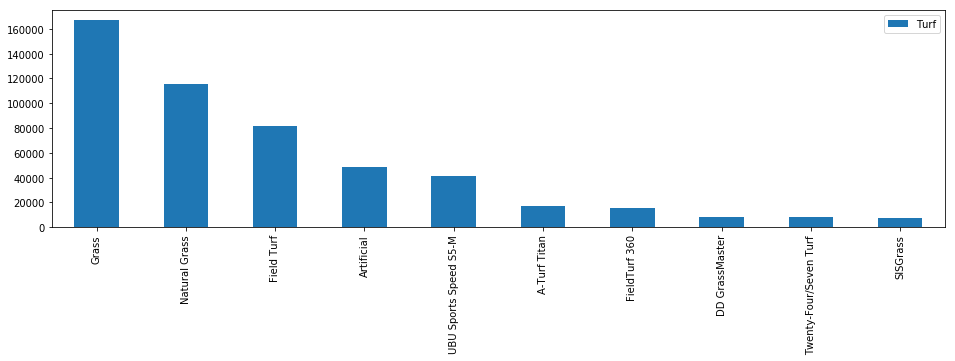

In [30]:
data[['Turf']].apply(pd.value_counts).plot(kind='bar', figsize=(16, 4))
plt.show()

**WindDirection**

In [31]:
wind = raw_data['WindDirection'].dropna().unique()
wind.sort()
print(len(wind), wind)

53 ['1' '13' '8' 'Calm' 'E' 'EAST' 'ENE' 'ESE' 'East' 'East North East'
 'East Southeast' 'From ESE' 'From NNE' 'From NNW' 'From S' 'From SSE'
 'From SSW' 'From SW' 'From W' 'From WSW' 'N' 'N-NE' 'NE' 'NNE' 'NNW' 'NW'
 'North' 'North East' 'North/Northwest' 'NorthEast' 'Northeast'
 'Northwest' 'S' 'SE' 'SSE' 'SSW' 'SW' 'South' 'South Southeast'
 'South Southwest' 'SouthWest' 'Southeast' 'Southwest' 'W' 'W-NW' 'W-SW'
 'WNW' 'WSW' 'West' 'West Northwest' 'West-Southwest' 'from W' 's']


The data is super dirty. At first we will get rid of 'From' suffix and '-' between cardinal directions

In [32]:
data['WindDirection'] = raw_data['WindDirection'].str.upper()\
                                                 .str.replace(' ', '')\
                                                 .str.replace('FROM', '')\
                                                 .str.replace('-', '')

wind = data['WindDirection'].dropna().unique()
wind.sort()
print(len(wind), wind)

35 ['1' '13' '8' 'CALM' 'E' 'EAST' 'EASTNORTHEAST' 'EASTSOUTHEAST' 'ENE'
 'ESE' 'N' 'NE' 'NNE' 'NNW' 'NORTH' 'NORTH/NORTHWEST' 'NORTHEAST'
 'NORTHWEST' 'NW' 'S' 'SE' 'SOUTH' 'SOUTHEAST' 'SOUTHSOUTHEAST'
 'SOUTHSOUTHWEST' 'SOUTHWEST' 'SSE' 'SSW' 'SW' 'W' 'WEST' 'WESTNORTHWEST'
 'WESTSOUTHWEST' 'WNW' 'WSW']


Next we will unify all directions

In [33]:
to_replace = {
              'NORTH/NORTHWEST'   : 'NNW',
              'SOUTHEAST'         : 'SE',
              'SOUTHWEST'         : 'SW',
              'NORTHEAST'         : 'NE',
              'NORTHWEST'         : 'NW',
              'EAST'              : 'E',
              'NORTH'             : 'N',
              'SOUTH'             : 'S',
              'WEST'              : 'W'
}

for word in to_replace.keys():
    data['WindDirection'] = data['WindDirection'].str.replace(word, to_replace[word])

wind = data['WindDirection'].dropna().unique()
wind.sort()
print(len(wind), wind)

20 ['1' '13' '8' 'CALM' 'E' 'ENE' 'ESE' 'N' 'NE' 'NNE' 'NNW' 'NW' 'S' 'SE'
 'SSE' 'SSW' 'SW' 'W' 'WNW' 'WSW']


And finally we will substitute numbers with nones as it is obviously a mistake

In [34]:
to_replace = {'1'   : np.nan,
              '13'  : np.nan,
              '8'   : np.nan
}

data['WindDirection'] = data['WindDirection'].apply(lambda x: to_replace[x] if x in to_replace.keys() else x)

wind = data['WindDirection'].dropna().unique()
wind.sort()
print(len(wind), wind)

17 ['CALM' 'E' 'ENE' 'ESE' 'N' 'NE' 'NNE' 'NNW' 'NW' 'S' 'SE' 'SSE' 'SSW'
 'SW' 'W' 'WNW' 'WSW']


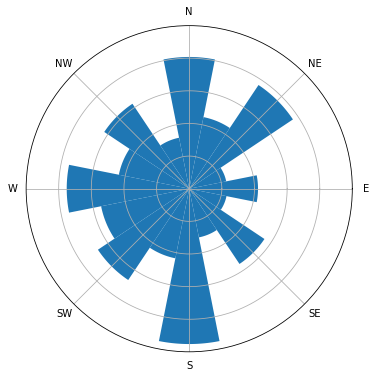

In [35]:
plt.figure(figsize=(6, 6))
directions = data[data['WindDirection'] != 'CALM']['WindDirection'].dropna().value_counts()
directions = directions.reindex(index=['E', 'ENE', 'NE', 'NNE', 
                                       'N', 'NNW', 'NW', 'WNW', 
                                       'W', 'WSW', 'SW', 'SSW', 
                                       'S', 'SSE', 'SE', 'ESE'])

theta = np.linspace(0.0, 2 * np.pi, len(directions), endpoint=False)
ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, directions.values, width = (2*np.pi) / len(directions))
ax.set_xticklabels(['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE'])
ax.set_yticklabels([])

plt.show()

**WindSpeed**

In [36]:
windSpeed = raw_data['WindSpeed'].dropna().unique()
print(len(windSpeed), windSpeed)

58 [8.0 6.0 10.0 9.0 11.0 7.0 5.0 2.0 12.0 1 3 4 13 '10' '5' '6' '4' '8' '0'
 'SSW' 14.0 0.0 15.0 17.0 18.0 16.0 '11-17' '16' '14' '13' '12' '23' '7'
 '9' '3' '17' '14-23' '1' '13 MPH' 24.0 '15' '12-22' '2' '4 MPh'
 '15 gusts up to 25' '11' '10MPH' '10mph' '22' 'E' '7 MPH' 'Calm' '6 mph'
 '19' 'SE' '20' '10-20' '12mph']


The data is very ununiform =( Some of the values are floats, some integers, some strings and some are even intervals. Ok, let's clear it

In [37]:
def process_raw_speed(speed):
    # try to simply convert to int
    try:
        return float(speed)
    except ValueError:
        pass

    if isinstance(speed, str): 
        numbers = [int(s) for s in re.findall(r'[0-9]+', speed)]
        if len(numbers) == 0:
            return np.nan

        # we will sumstitude intervals with its mean
        return np.mean(numbers)
    
    return speed
    
data['WindSpeed'] = raw_data['WindSpeed'].apply(process_raw_speed)

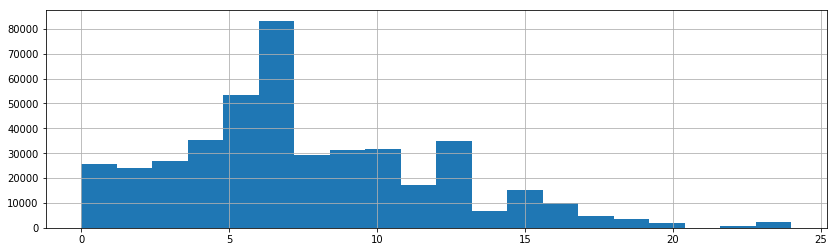

In [38]:
data['WindSpeed'].hist(figsize=(14, 4), bins=20)
plt.show()

**GameWeather** is the most difficult column for processing

In [39]:
weather = data['GameWeather'].str.lower().dropna().unique()
weather.sort()
print(len(weather), weather)

54 ['30% chance of rain' 'clear' 'clear and cold' 'clear and cool'
 'clear and sunny' 'clear and warm' 'clear skies' 'cloudy'
 'cloudy and cold' 'cloudy and cool'
 'cloudy with periods of rain, thunder possible. winds shifting to wnw, 10-20 mph.'
 'cloudy, 50% change of rain' 'cloudy, chance of rain'
 'cloudy, fog started developing in 2nd quarter'
 'cloudy, light snow accumulating 1-3"' 'cloudy, rain' 'cold'
 'controlled climate' 'coudy' 'fair' 'hazy' 'heavy lake effect snow'
 'indoor' 'indoors' 'light rain' 'mostly cloudy' 'mostly coudy'
 'mostly sunny' 'mostly sunny skies' 'n/a (indoors)' 'n/a indoor'
 'overcast' 'partly clear' 'partly cloudy' 'partly clouidy' 'partly sunny'
 'party cloudy' 'rain' 'rain chance 40%' 'rain likely, temps in low 40s.'
 'rain shower' 'rainy' 'scattered showers' 'showers' 'snow' 'sun & clouds'
 'sunny' 'sunny and clear' 'sunny and cold' 'sunny and warm' 'sunny skies'
 'sunny, highs to upper 80s' 'sunny, windy' 't: 51; h: 55; w: nw 10 mph']


TODO: decide what to do with it, may be NLP

### OffensePersonnel / DefencePersonnel

In [51]:
offense = raw_data['OffensePersonnel'].dropna().unique()
offense.sort()
print(len(offense), offense)

56 ['0 RB, 0 TE, 5 WR' '0 RB, 1 TE, 4 WR' '0 RB, 2 TE, 3 WR'
 '0 RB, 3 TE, 2 WR' '1 RB, 0 TE, 3 WR,1 DB' '1 RB, 0 TE, 4 WR'
 '1 RB, 1 TE, 2 WR,1 DB' '1 RB, 1 TE, 2 WR,1 DL' '1 RB, 1 TE, 2 WR,1 LB'
 '1 RB, 1 TE, 3 WR' '1 RB, 2 TE, 1 WR,1 DB' '1 RB, 2 TE, 1 WR,1 DL'
 '1 RB, 2 TE, 1 WR,1 LB' '1 RB, 2 TE, 2 WR' '1 RB, 2 TE, 3 WR'
 '1 RB, 3 TE, 0 WR,1 DB' '1 RB, 3 TE, 0 WR,1 DL' '1 RB, 3 TE, 0 WR,1 LB'
 '1 RB, 3 TE, 1 WR' '1 RB, 4 TE, 0 WR' '2 QB, 1 RB, 0 TE, 3 WR'
 '2 QB, 1 RB, 1 TE, 2 WR' '2 QB, 1 RB, 2 TE, 1 WR'
 '2 QB, 1 RB, 3 TE, 0 WR' '2 QB, 2 RB, 0 TE, 2 WR'
 '2 QB, 2 RB, 1 TE, 1 WR' '2 QB, 2 RB, 2 TE, 0 WR'
 '2 QB, 3 RB, 1 TE, 0 WR' '2 RB, 0 TE, 3 WR' '2 RB, 1 TE, 1 WR,1 DB'
 '2 RB, 1 TE, 2 WR' '2 RB, 2 TE, 0 WR,1 DL' '2 RB, 2 TE, 1 WR'
 '2 RB, 3 TE, 0 WR' '2 RB, 3 TE, 1 WR' '3 RB, 0 TE, 2 WR'
 '3 RB, 1 TE, 1 WR' '3 RB, 2 TE, 0 WR' '6 OL, 0 RB, 2 TE, 2 WR'
 '6 OL, 1 RB, 0 TE, 3 WR' '6 OL, 1 RB, 1 TE, 0 WR,2 DL'
 '6 OL, 1 RB, 1 TE, 1 WR,1 DL' '6 OL, 1 RB, 1 TE, 2 WR'
 '6 OL, 1 RB, 2 

In [52]:
defense = raw_data['DefensePersonnel'].dropna().unique()
defense.sort()
print(len(defense), defense)

38 ['0 DL, 4 LB, 7 DB' '0 DL, 5 LB, 6 DB' '0 DL, 6 LB, 5 DB'
 '1 DL, 2 LB, 8 DB' '1 DL, 3 LB, 7 DB' '1 DL, 4 LB, 6 DB'
 '1 DL, 5 LB, 5 DB' '2 DL, 2 LB, 7 DB' '2 DL, 3 LB, 6 DB'
 '2 DL, 4 LB, 4 DB, 1 OL' '2 DL, 4 LB, 5 DB' '2 DL, 5 LB, 4 DB'
 '3 DL, 1 LB, 7 DB' '3 DL, 2 LB, 6 DB' '3 DL, 3 LB, 5 DB'
 '3 DL, 4 LB, 3 DB, 1 OL' '3 DL, 4 LB, 4 DB' '3 DL, 5 LB, 3 DB'
 '4 DL, 0 LB, 7 DB' '4 DL, 1 LB, 6 DB' '4 DL, 2 LB, 5 DB'
 '4 DL, 3 LB, 4 DB' '4 DL, 4 LB, 3 DB' '4 DL, 5 LB, 1 DB, 1 OL'
 '4 DL, 5 LB, 2 DB' '4 DL, 6 LB, 1 DB' '5 DL, 1 LB, 5 DB'
 '5 DL, 2 LB, 4 DB' '5 DL, 3 LB, 2 DB, 1 OL' '5 DL, 3 LB, 3 DB'
 '5 DL, 4 LB, 1 DB, 1 OL' '5 DL, 4 LB, 2 DB' '5 DL, 5 LB, 1 DB'
 '6 DL, 1 LB, 4 DB' '6 DL, 2 LB, 3 DB' '6 DL, 3 LB, 2 DB'
 '6 DL, 4 LB, 1 DB' '7 DL, 2 LB, 2 DB']


DefensePersonnel and OffensePersonnel describes team positional grouping. They are not noisy, so we will not change them for now.

### TimeHandoff, TimeSnap

Parse it to the datetime

In [53]:
time_handoff = raw_data['TimeHandoff'].dropna().unique()
time_handoff.sort()
print(len(time_handoff), time_handoff)

22935 ['2017-09-08T00:44:06.000Z' '2017-09-08T00:44:27.000Z'
 '2017-09-08T00:45:17.000Z' ... '2018-12-31T04:01:05.000Z'
 '2018-12-31T04:01:45.000Z' '2018-12-31T04:18:19.000Z']


In [55]:
time_snap = raw_data['TimeSnap'].dropna().unique()
time_snap.sort()
print(len(time_snap), time_snap)

22943 ['2017-09-08T00:44:05.000Z' '2017-09-08T00:44:26.000Z'
 '2017-09-08T00:45:15.000Z' ... '2018-12-31T04:01:04.000Z'
 '2018-12-31T04:01:44.000Z' '2018-12-31T04:18:18.000Z']


TimeHandoff and TimeSnap are just datetime, so let's parse it.

In [57]:
data['TimeHandoff'] = raw_data['TimeHandoff'].apply(pd.to_datetime)
data['TimeSnap'] = raw_data['TimeSnap'].apply(pd.to_datetime)

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509762 entries, 0 to 509761
Data columns (total 49 columns):
GameId                    509762 non-null int64
PlayId                    509762 non-null int64
Team                      509762 non-null object
X                         509762 non-null float64
Y                         509762 non-null float64
S                         509762 non-null float64
A                         509762 non-null float64
Dis                       509762 non-null float64
Orientation               509744 non-null float64
Dir                       509748 non-null float64
NflId                     509762 non-null int64
DisplayName               509762 non-null object
JerseyNumber              509762 non-null int64
Season                    509762 non-null int64
YardLine                  509762 non-null int64
Quarter                   509762 non-null int64
GameClock                 509762 non-null datetime64[ns]
PossessionTeam            509762 non-null object

# Initial data exploration

### Histograms

Firstly, let's look to the histogram of each numeric feature.

In [63]:
data_numeric = data.select_dtypes(include=[np.number])
data_numeric.head()

,GameId,PlayId,X,Y,S,A,Dis,Orientation,Dir,NflId,...,VisitorScoreBeforePlay,NflIdRusher,DefendersInTheBox,Yards,PlayerHeight,PlayerWeight,Week,Temperature,Humidity,WindSpeed
0,2017090700,20170907000118,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,...,0,2543773,6.0,8,182.88,212,1,63.0,77.0,8.0
1,2017090700,20170907000118,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,...,0,2543773,6.0,8,190.50,288,1,63.0,77.0,8.0
2,2017090700,20170907000118,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,...,0,2543773,6.0,8,190.50,270,1,63.0,77.0,8.0
3,2017090700,20170907000118,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,...,0,2543773,6.0,8,190.50,245,1,63.0,77.0,8.0
4,2017090700,20170907000118,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,...,0,2543773,6.0,8,182.88,206,1,63.0,77.0,8.0


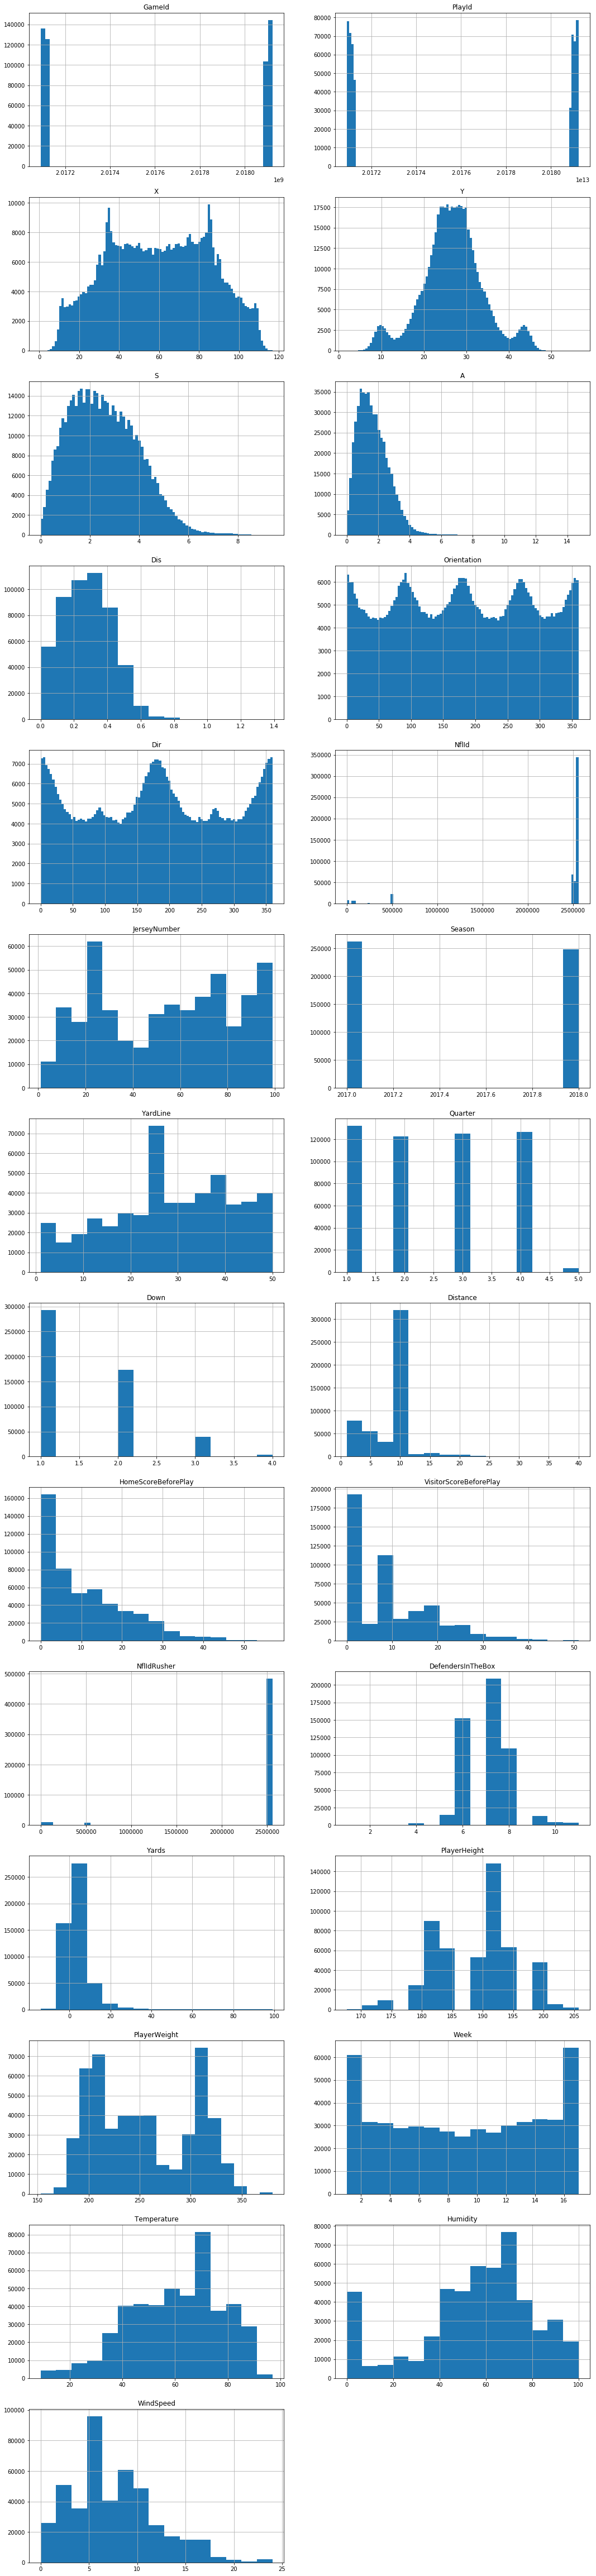

In [74]:
n_columns = 2
n_rows = (data_numeric.shape[1] - 1) // n_columns + 1

plt.figure(figsize=(n_columns * 9, n_rows * 6))

for i, column in enumerate(data_numeric.columns):
    plt.subplot(n_rows, n_columns, i+1)
    data_numeric[column].hist(bins=min(100, max(15, len(data_numeric[column].unique()) // 10)))
    plt.title(column)
    
plt.show()

Interesting columns: X, Y (unobvious patterns), Orientation, Dir (interesting shape of histogram, cycle structure, few peaks), PlayerWeight, JerseyNumber (few peaks).

### Correlation

Then let's compute correlation coefficient between every pair of features. 

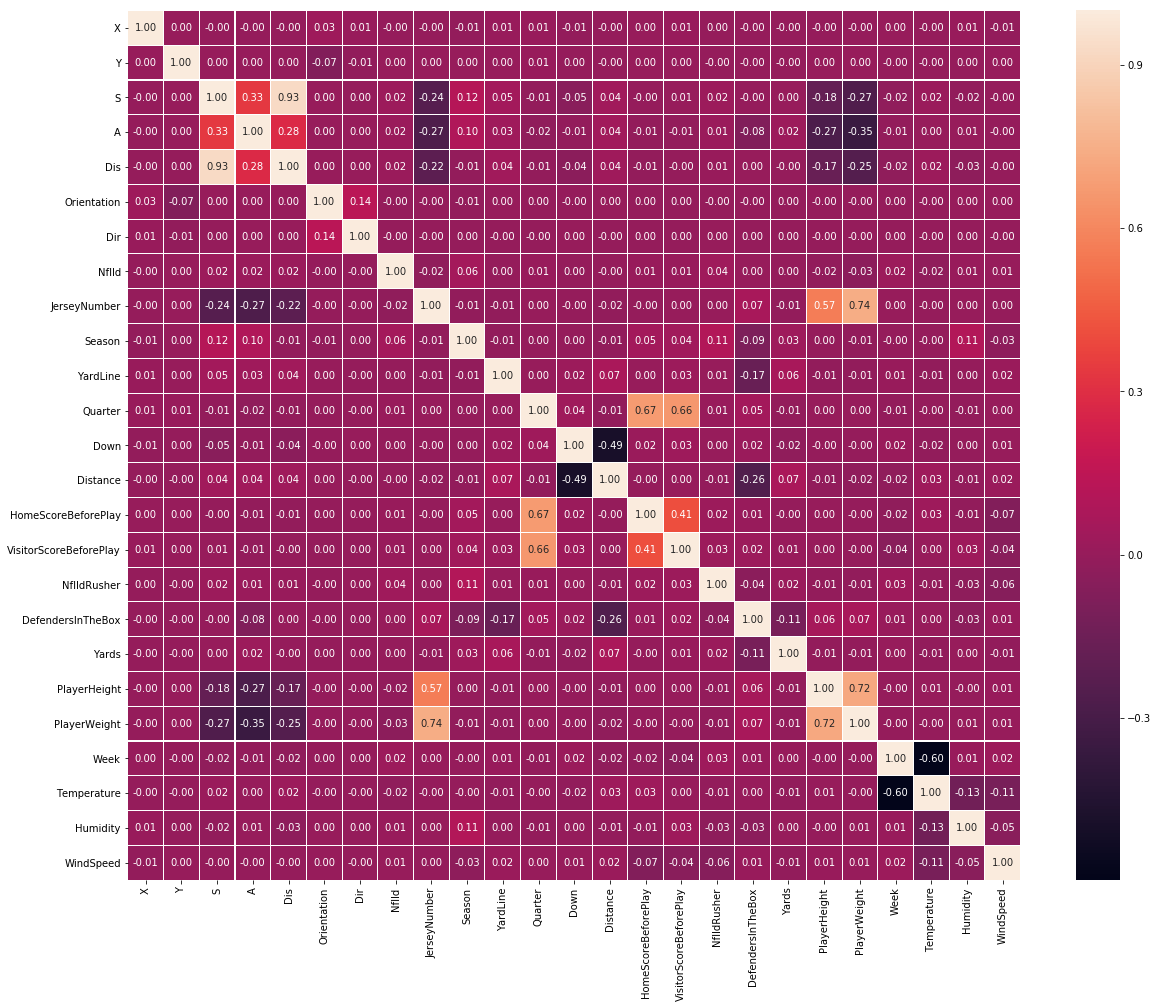

In [79]:
plt.figure(figsize=(20, 16))
sns.heatmap(data.iloc[:,2:].corr(),annot=True, linewidths=.1, fmt='.2f')

plt.show()

Relatively strong correlations: Distance-Down, PlayerWeight-A (heavy players are slow, ha-ha), Temperature-Week (very logical too), PlayerHeight-PlayerWeight, PlayerHeight/Weight-JerseyNumber (it can be interesting to understand NFL jersey numbering system) and few others. Unfortunately, there are no strong linear correlation with Yards (target variable).